# Towards Evaluating Creativity in Language

This notebook is a prototype for evaluating creativity in language. It is based on the paper [Towards Evaluating Creativity in Language](https://arxiv.org/abs/1904.09751) by [Rudinger et al.](https://arxiv.org/abs/1904.09751) (2019).
^ bruh copilot at it again

In [1]:
# Imports...
from typing import Generator

from nltk.tag.mapping import map_tag
import torch
from nltk.corpus import gutenberg
from nltk.text import Text
from nltk.corpus import brown, wordnet as wn
from nltk.tag.mapping import map_tag
import nltk

from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

sns.set_theme()


# handy features for downloading the datasets

# nltk.download()

# Some stuff I did for the prototype POS tagging, using the Penn Treebank tagger, until I had to meet with the brown corpus.
# Imo, the Universal tagset is more simple.
# tags = set(tag for _, tag in postagged_words)
# tags = {'$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT',
#         'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``'}
# tag_to_embed = {tag: i for i, tag in enumerate(tags)}
# embed_to_tag = {i: tag for i, tag in enumerate(tags)}

# # We wanted to unify the tags to a smaller set of tags, so we could use a smaller embedding layer. (yeah, this is why, copilot)
# # Punctuation
# tag_map = dict.fromkeys(['$', "''", '(', ')', ',', '.', ':', '``'], '.')
# # Nouns
# tag_map.update(dict.fromkeys(['NN', 'NNP', 'NNPS', 'NNS'], 'N'))
# # Verbs
# tag_map.update(dict.fromkeys(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'], 'V'))
# # Adjectives
# tag_map.update(dict.fromkeys(['JJ', 'JJR', 'JJS'], 'J'))
# # Adverbs
# tag_map.update(dict.fromkeys(['RB', 'RBR', 'RBS'], 'R'))
# # Prepositions
# tag_map.update(dict.fromkeys(['IN'], 'Prep'))
# # Determiners
# tag_map.update(dict.fromkeys(['DT', 'PDT', 'WDT'], 'D'))
# # Pronouns
# tag_map.update(dict.fromkeys(['PRP', 'PRP$', 'WP', 'WP$'], 'P'))
# # Conjunctions
# tag_map.update(dict.fromkeys(['CC', 'TO'], 'C'))
# # Auxiliary
# tag_map.update(dict.fromkeys(['MD'], 'A'))
# # Miscellaneous
# tag_map.update(dict.fromkeys(
#     ['EX', 'FW', 'RP', 'UH', 'CD', 'POS', 'WRB'], 'M'))
# simple_tags = set(tag_map.values())
# tag_to_embed_2 = {tag: i for i, tag in enumerate(simple_tags)}
# embed_to_tag_2 = {i: tag for i, tag in enumerate(simple_tags)}
# # Translate simple tags to human-readable
# tag_to_human = {'A': 'Auxiliary', 'C': 'Conjunction', 'D': 'Determiner', 'J': 'Adjective', 'M': 'Miscellaneous',
#                 'N': 'Noun', 'P': 'Pronoun', 'Prep': 'Preposition', 'R': 'Adverb', 'V': 'Verb', '.': 'Punctuation'}

tags = nltk.tag.mapping._UNIVERSAL_TAGS

tag_to_embed = {tag: i for i, tag in enumerate(tags)}
embed_to_tag = {i: tag for i, tag in enumerate(tags)}

## Load datasets
Note that the following snippet will download some resources and cache them in the `data` directory.

In [2]:
# import requests
# import pathlib
# from datasets.load import load_dataset

# # Check if the file exists, otherwise download it

# cloze_train_path = pathlib.Path("./data/cloze_test_2018_train.csv")
# if not cloze_train_path.exists():
#     cloze_train_path.write_bytes(requests.get("https://goo.gl/0OYkPK").content)

# cloze_val_path = pathlib.Path("./data/cloze_test_2018_val.csv")
# if not cloze_val_path.exists():
#     cloze_val_path.write_bytes(requests.get("https://goo.gl/XWjas1").content)

# cloze_test_path = pathlib.Path("./data/cloze_test_2018_test.csv")
# if not cloze_test_path.exists():
#     cloze_test_path.write_bytes(requests.get("https://goo.gl/BcTtB4").content)

# tiny_shakespeare_path = pathlib.Path("./data/tiny_shakespeare.txt")
# if not tiny_shakespeare_path.exists():
#     tiny_shakespeare_path.write_bytes(requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt").content)

# val_ds = pd.read_csv(cloze_val_path)
# # val_ds = load_dataset('csv', "val", data_files=cloze_val_path.__str__())

# # tiny_shakespeare = load_dataset('tiny_shakespeare')
# with open(tiny_shakespeare_path, 'r') as f:
#     tiny_shakespeare = f.read()


# # Load the datasets later
# # train_ds = load_dataset('csv', "train", data_files=cloze_train_path.__str__())
# # test_ds = load_dataset('csv', "test", data_files=cloze_test_path.__str__())


### Potential creativity measures
#### Usage of less common vocabulary uncommon words
**Example:**
- "The quick brown fox jumps over the lazy dog."
- "The swift hazel-furred fox leaps over the idle dog."

**Idea:**

Adapt resources such as WordNet for finding semantically similar words and compare them to their most used synonym. Notion: The more uncommon the word, the more creative the sentence.
Potential problems: words could be too far off from their actual meaning in the context. For example, here "leaps" is a synonym for "jumps", but using the word "vaults" or "springs" might not fit the context.


#### Comparing alternatives for bi(+)grams 
(Generally, we want to narrow down on adjectives and noun phrases, but this could be expanded to verb phrases for example.)  
**Two variants:**
1. Compare how much the original word deviates in comparison to contextual synonyms/alternatives. That is, compare $ P(w_{original}|context) $ with $ \{P(w| context) | w \text{ in the set of alternative continuations}\} $. **This is somewhat akin to the perplexity measure, I believe?**
   - *Example:* (The following has been generated by Copilot) Given the sentence "The quick brown fox jumps over the lazy dog.", the context word is "fox" and the alternative contexts are "dog" and "cat". The probability of "jumps" given "fox" is compared to the probabilities of "jumps" given "dog" and "cat". 
   - **Alternatively**, to simplify the formulas, we can compare the deviation of probability $ P(w_{original}|context) $ with respect to the likeliest/largest/maximum element in the set of probability distribution described above, i.e. $\max (\{ P(w|context) | w \in S_{Alternatives}\})$ 


2. Compare the deviation of probability $ P(word|modifier) $ with respect to the set $ \{P(word| alt) | alt \text{ in the set of alternative modifiers}\}$
   - *Example:* Given the sentence "The quick *brown* **fox** jumps over the lazy dog.", the $word$ is **"fox"** and the $modifier$ is *"brown"*. Then, the alternative modifiers can be "black", "reddish", or even "blue".
   - This can be summarised by doing evaluation on the noun phrase level. I'd personally prefer focusing on the prepositional modifier words.

In [3]:
class CreativityBenchmark:
    def __init__(self, raw_text: str):
        self.raw_text = raw_text
        self.words = nltk.word_tokenize(raw_text, preserve_line=True)
        self.sents = nltk.sent_tokenize(self.raw_text)
        self.tokenized_sents = [nltk.word_tokenize(sent) for sent in self.sents]
        # self.sents = [nltk.word_tokenize(sent) for sent in self.sents]

        # Initialize a list to hold the POS tag counts for each sentence
        self.postag_counts : list[nltk.FreqDist] = []
        self.tagset = ""

    def ngrams(self, n, **kwargs):
        return nltk.ngrams(self.raw_text, n, kwargs)

    def sent_postag_counts(self, tagset:str = None) -> list[nltk.FreqDist]:
        """Returns sentence-level counts of POS tags for each sentence in the text. """
        if self.postag_counts != [] and self.tagset == tagset:
            return self.postag_counts
        else:
            self.tagset = tagset
            # Collect POS data for each sentence
            for sentence in nltk.pos_tag_sents(self.tokenized_sents, tagset=tagset):
                # Initialize a counter for the POS tags on the sentence level
                lib = nltk.FreqDist()
                for _, token in sentence:
                    lib[token] += 1

                self.postag_counts.append(lib)

            return self.postag_counts

    def book_postag_counts(self, tagset) -> nltk.FreqDist:
        """Get a counter object for the Parts of Speech in the whole book."""
        # Note this approach does not give completely equal results to get_sent_postag_counts despite being a bit faster
        # freq_dist = nltk.FreqDist(self.words)
        # tagged = nltk.pos_tag(freq_dist.keys())

        # count = nltk.FreqDist()
        # for (_, val), (_, tag) in zip(freq_dist.items(), tagged):
        #     count[tag] += val

        # Opt to use this instead for consistency.
        book_total_postags = nltk.FreqDist()
        for l in self.sent_postag_counts(tagset=tagset):
            book_total_postags += l
        return book_total_postags

    def num_tokens_per_sentence(self) -> Generator[int, None, None]:
        return (len(sentence) for sentence in self.tokenized_sents)

    def total_tokens_per_sentence(self) -> int:
        return sum(self.num_tokens_per_sentence())

    def avg_tokens_per_sentence(self) -> float:
        return sum(self.num_tokens_per_sentence())/len(self.sents)

bench = CreativityBenchmark(gutenberg.raw("austen-emma.txt"))


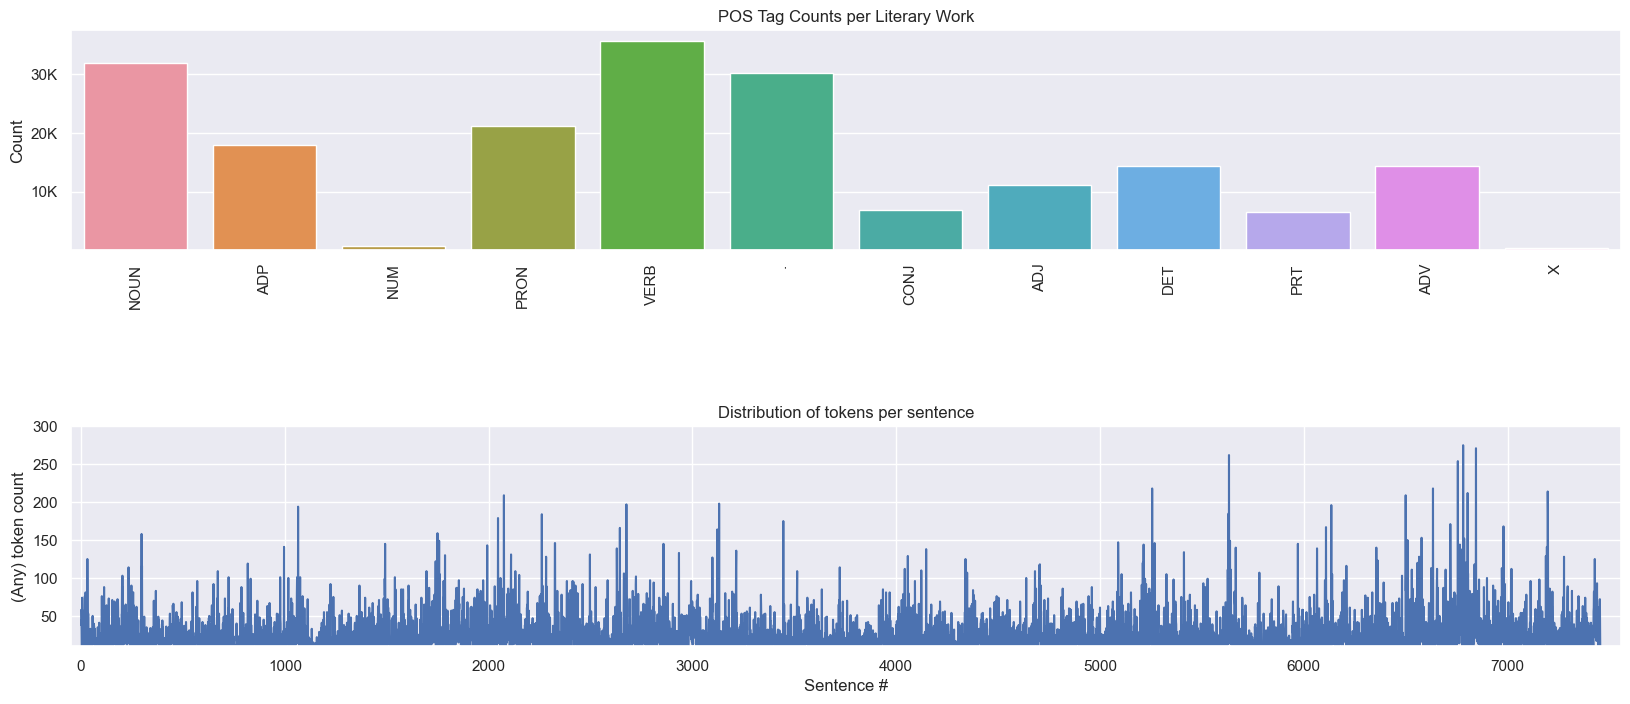

In [4]:
# Potentially consider color schemes for nounds, adjectives, etc., not just a random one
book_total_postags = bench.book_postag_counts(tagset='universal')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
sns.barplot(x=list(book_total_postags.keys()), y=list(
    book_total_postags.values()), label="Emma", ax=ax1)
ax1.set_title("POS Tag Counts per Literary Work")
ax1.set_ylabel("Count")
ax1.set_ylim(bottom=30)
# Set counts to appear with the K suffix
ax1.yaxis.set_major_formatter(plt.FuncFormatter(
    lambda x, loc: "{:,}K".format(int(x/1000))))
ax1.tick_params(axis='x', labelrotation=90)

num_tokens_per_sentence = np.array(list(bench.num_tokens_per_sentence()))
# x = np.arange(0, num_tokens_per_sentence.shape[0])
# spline = make_interp_spline(x, num_tokens_per_sentence, 3, bc_type='natural')
ax2.set(title="Distribution of tokens per sentence", xlabel="Sentence #",
        ylabel="(Any) token count", ylim=(10, 300), xlim=(-50, len(num_tokens_per_sentence) +100))
ax2.plot(num_tokens_per_sentence)

fig.subplots_adjust(hspace=0.8)

# Average number of tokens per sentence
avg_num_tokens = bench.avg_tokens_per_sentence()


Possible algorithm for measuring number of tokens per sentence:
1. Split the text into sentences using the sentence tokenizer.
2. For each sentence, split it into tokens using the word tokenizer.

Additionally, plot the distribution of the number of tokens per sentence.
Additionally, plot the distribution of different PoS tags per sentence.
Do this for a few genres and compare them. PLOT PLOTS PLOTS


In [5]:
sent_pos_tag_counts = bench.sent_postag_counts(tagset='universal')

df = pd.DataFrame(sent_pos_tag_counts)
df.fillna(0, inplace=True)

# # merge the columns of df with sum
# # Nouns
# df['NN'] = df['NN'] + df['NNS'] + df['NNP'] + df['NNPS']
# # Adjectives
# df['JJ'] = df['JJ'] + df['JJR'] + df['JJS']
# # Adverbs
# df['RB'] = df['RB'] + df['RBR'] + df['RBS']
# # Verbs
# df['VB'] = df['VB'] + df['VBD'] + df['VBG'] + df['VBN'] + df['VBP'] + df['VBZ']
# # Pronouns (includes wh-pronouns)
# df['PRP'] = df['PRP'] + df['PRP$'] + df['WP'] + df['WP$']
# # Determiners
# df['DT'] = df['DT'] + df['WDT'] + df['PDT']
# # Foreign words [FW]
# # Punctuation
# df['.'] = df['.'] + df[','] + df[':'] + df['``'] + \
#     df["''"] + df['('] + df[')'] + df['$']
# # Miscellaneous
# df['EX'] = df['EX'] + df['CC'] + df['CD'] + df['MD'] + df['UH']

# # Keep Nouns, Adjectives, Adverbs, Verbs, Pronouns, Determiners, Punctuation, Foreign words, and Miscellaneous
# df = pd.DataFrame(df, columns=['NN', 'JJ', 'RB',
#                   'VB', 'PRP', 'DT', '.', 'FW', 'EX'])
df = df.div(df.sum(axis=1), axis=0)


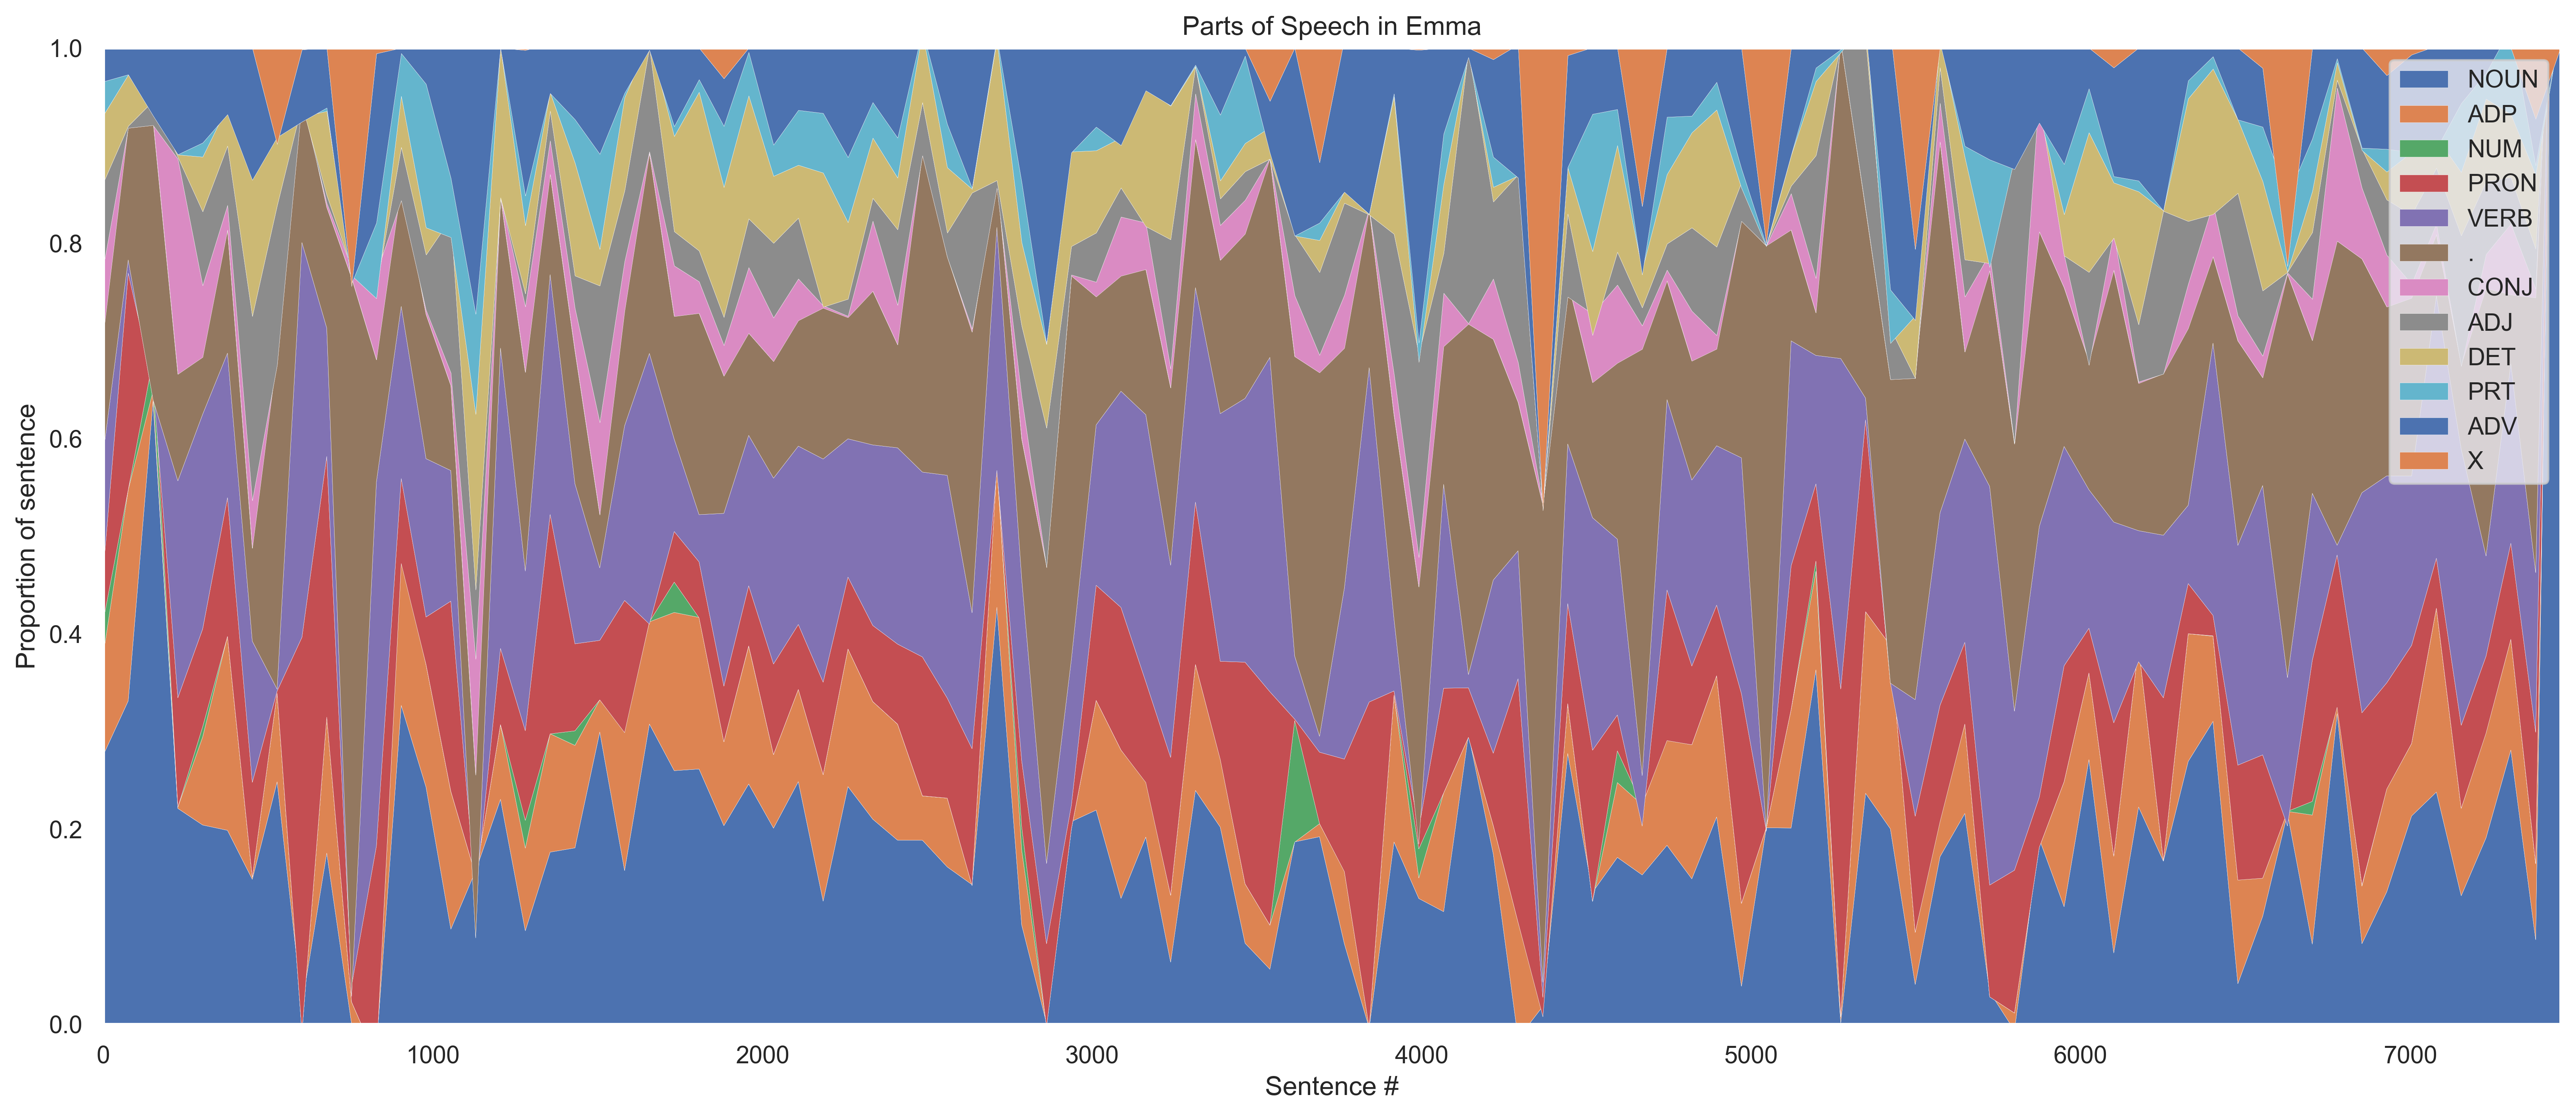

In [6]:
# Smooth out the curve

fig, ax = plt.subplots(figsize=(20, 8), dpi=400)
graphs = []
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, df.shape[0], 100)

for label in df.columns:
    spl = make_interp_spline(list(df.index), df[label], bc_type='natural')  # BSpline object
    power_smooth = spl(xnew)
    
    graphs.append(power_smooth)

ax.stackplot(xnew, *graphs, labels=df.columns, linewidth=0.1, colors=sns.color_palette("deep", n_colors=df.shape[1], as_cmap=True))
# Lineplot - unreadable
# sns.set_palette(sns.color_palette("bright", n_colors=df.shape[1], as_cmap=True))
# for graph, label in zip(graphs, df.columns):
#     ax.plot(xnew, graph, label = label, linewidth=0.5)
    
ax.set(xlim=(0, len(bench.sents)), ylim=(0, 1), title='Parts of Speech in Emma',
       xlabel='Sentence #', ylabel='Proportion of sentence')
ax.legend();


In [7]:
postagged_words = nltk.pos_tag(bench.words)
postagged_words = [(word, map_tag('en-ptb', 'universal', tag))
                   for word, tag in postagged_words]

# Show the most common collocations of POS tags
counter = torch.zeros((len(tags), len(tags)), dtype=torch.int32)
for pair_1, pair_2 in zip(postagged_words, postagged_words[1:]):
    counter[tag_to_embed[pair_1[1]], tag_to_embed[pair_2[1]]] += 1
# print(counter)


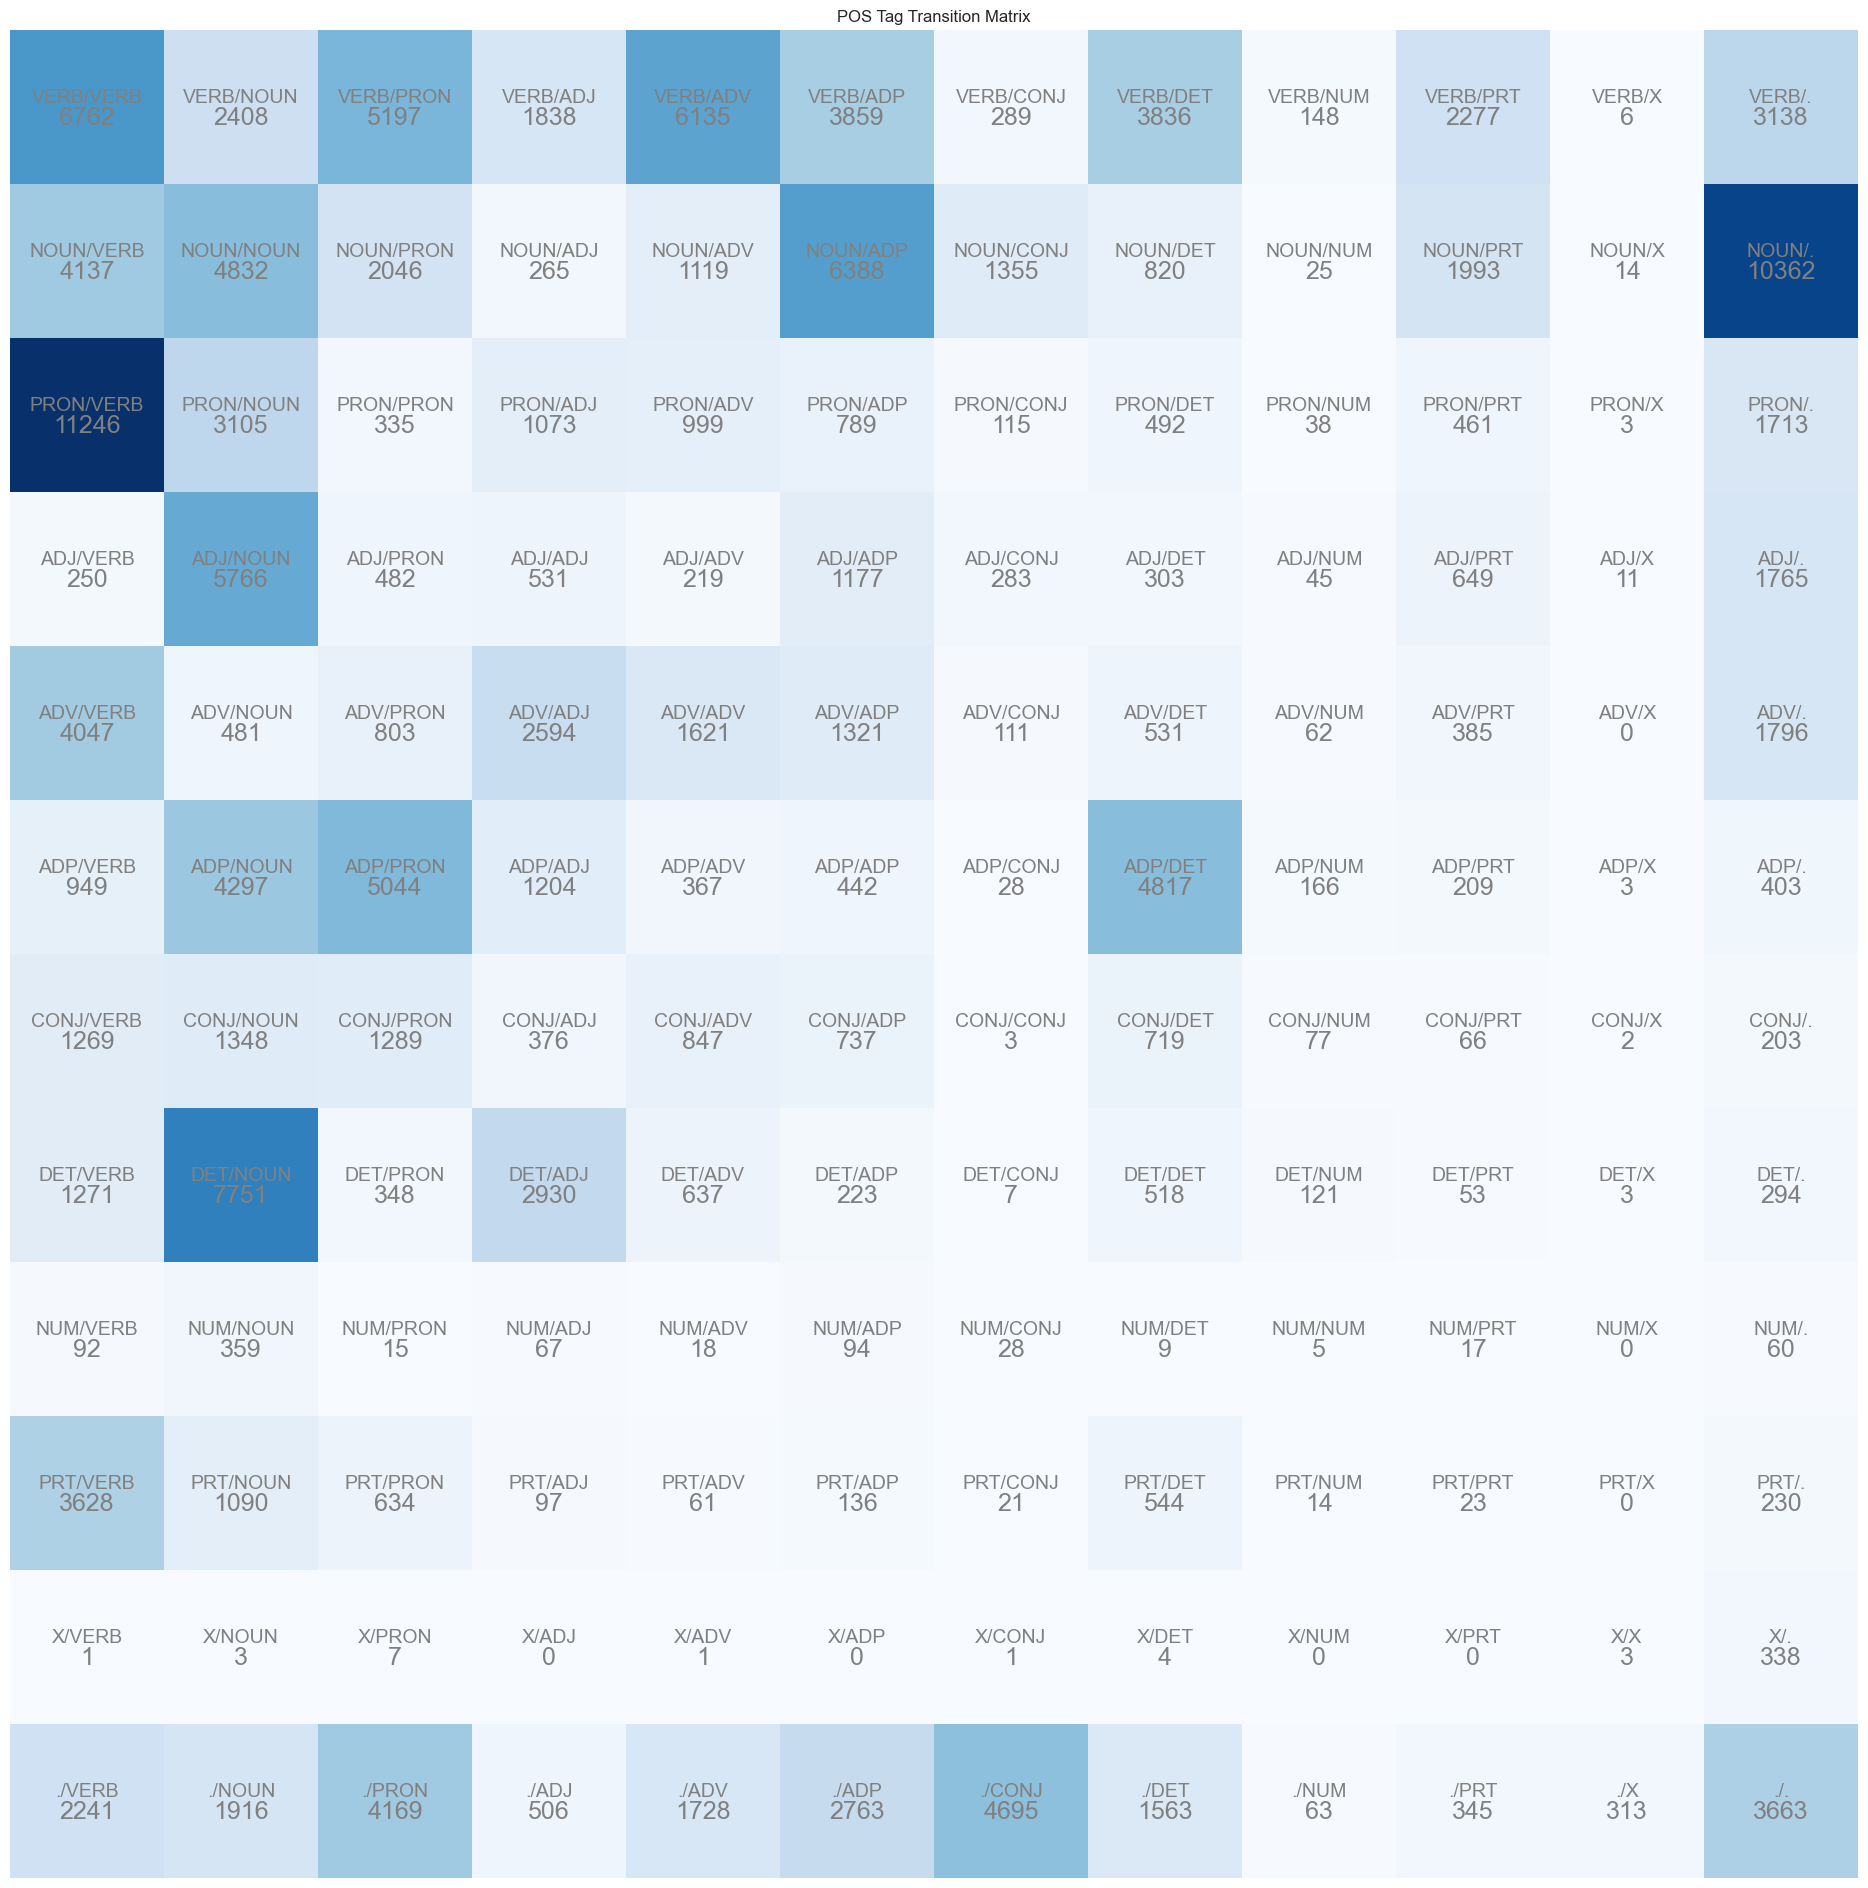

In [8]:
plt.figure(figsize=(24, 24))
plt.imshow(counter, cmap="Blues")
for i in range(counter.shape[0]):
    for j in range(counter.shape[1]):
        plt.text(j, i, embed_to_tag[i]+'/'+embed_to_tag[j], ha="center",
                 va="bottom", color="gray", fontdict={'size': 14})
        plt.text(j, i, counter[i, j].item(), ha="center",
                 va="top", color="gray", fontdict={'size': 18})

plt.title("POS Tag Transition Matrix")
plt.axis('off');


In [9]:
# Show the most common collocations of POS tags
brown_mystery_words = brown.tagged_words(categories='news', tagset='universal')

counter = torch.zeros((len(nltk.tag.mapping._UNIVERSAL_TAGS), len(
    nltk.tag.mapping._UNIVERSAL_TAGS)), dtype=torch.int32)
for pair_1, pair_2 in zip(brown_mystery_words, brown_mystery_words[1:]):
    counter[tag_to_embed[pair_1[1]], tag_to_embed[pair_2[1]]] += 1
# print(counter)

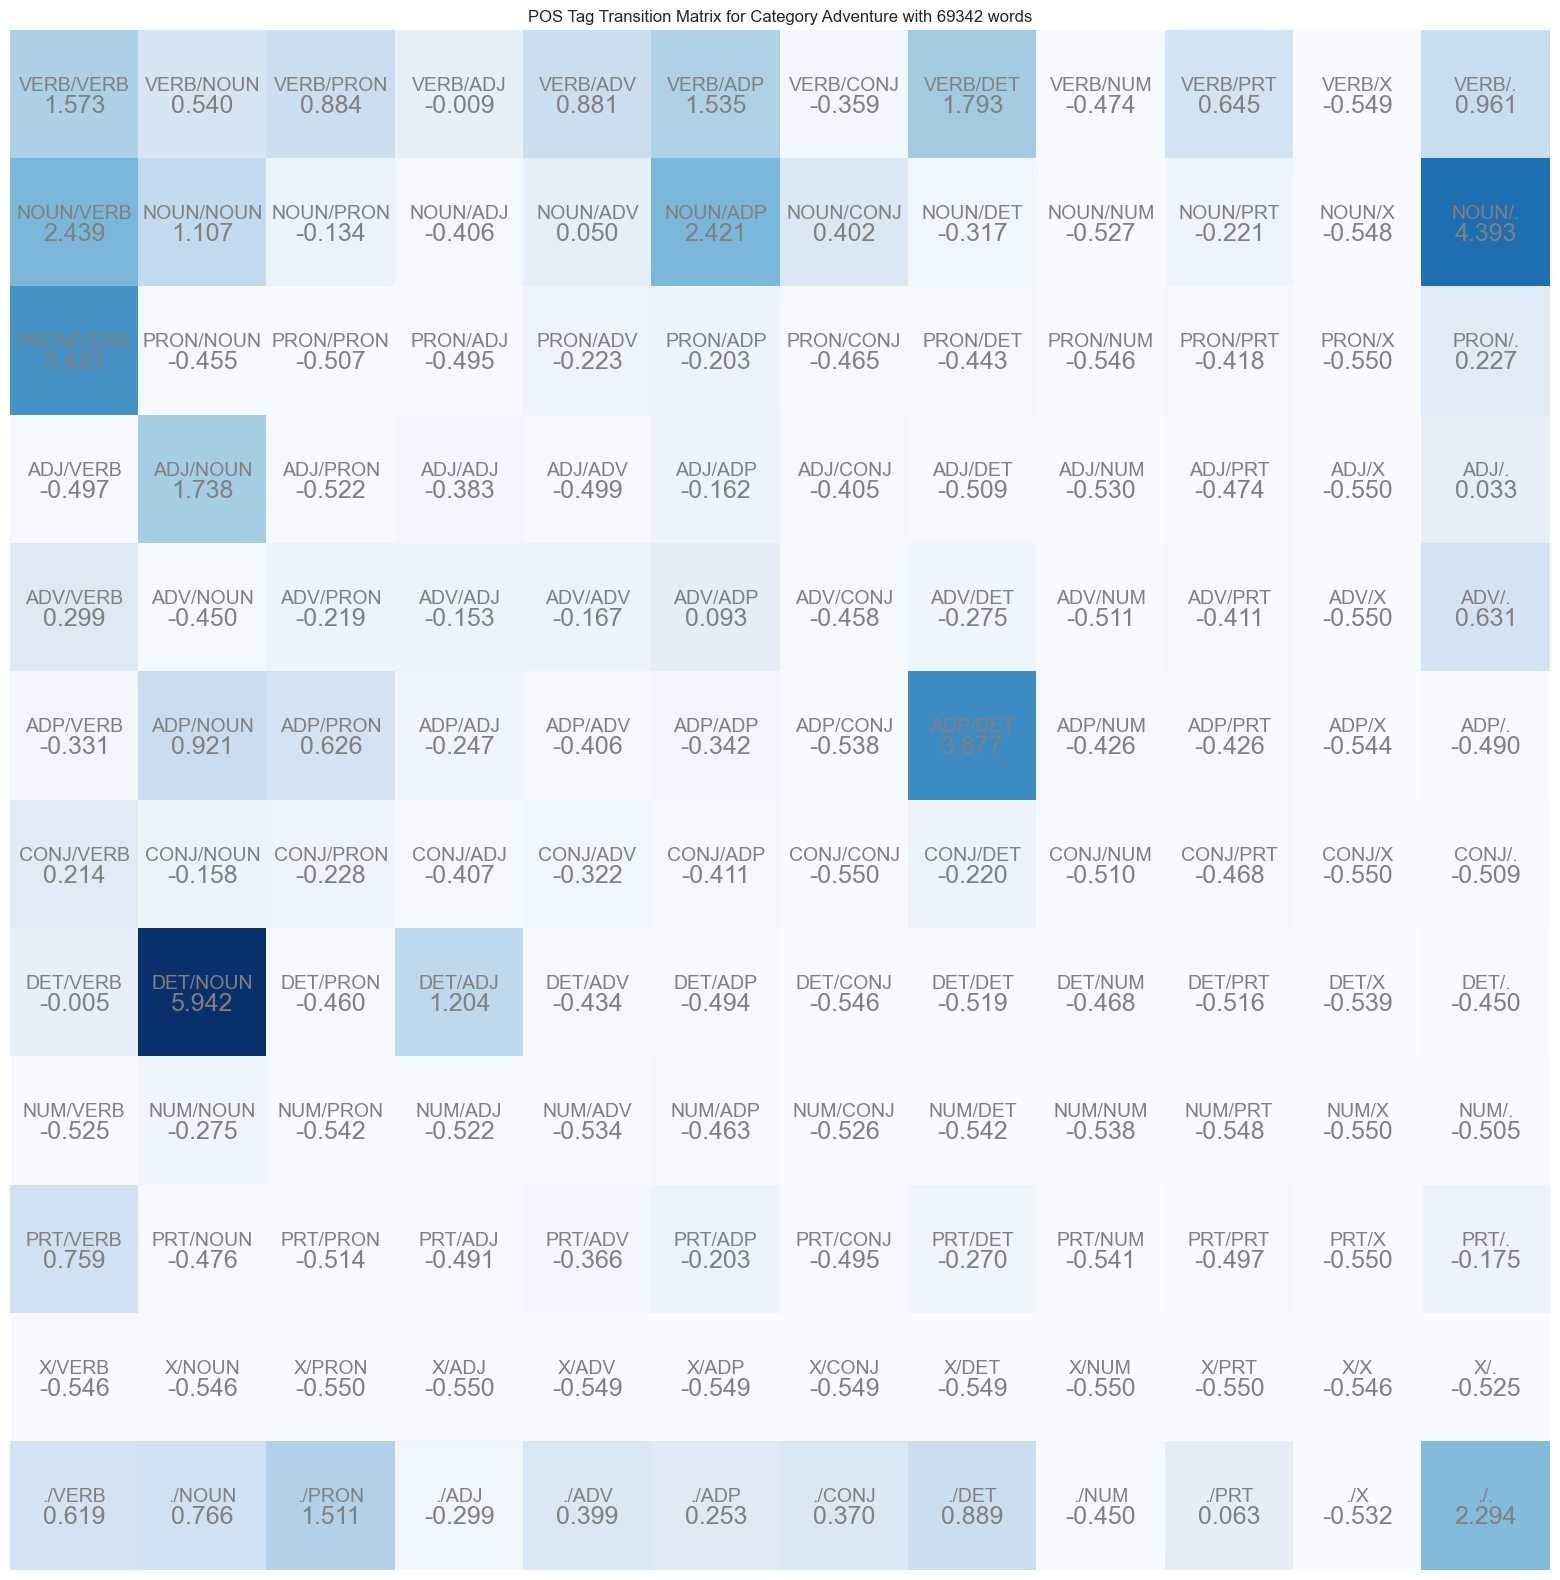

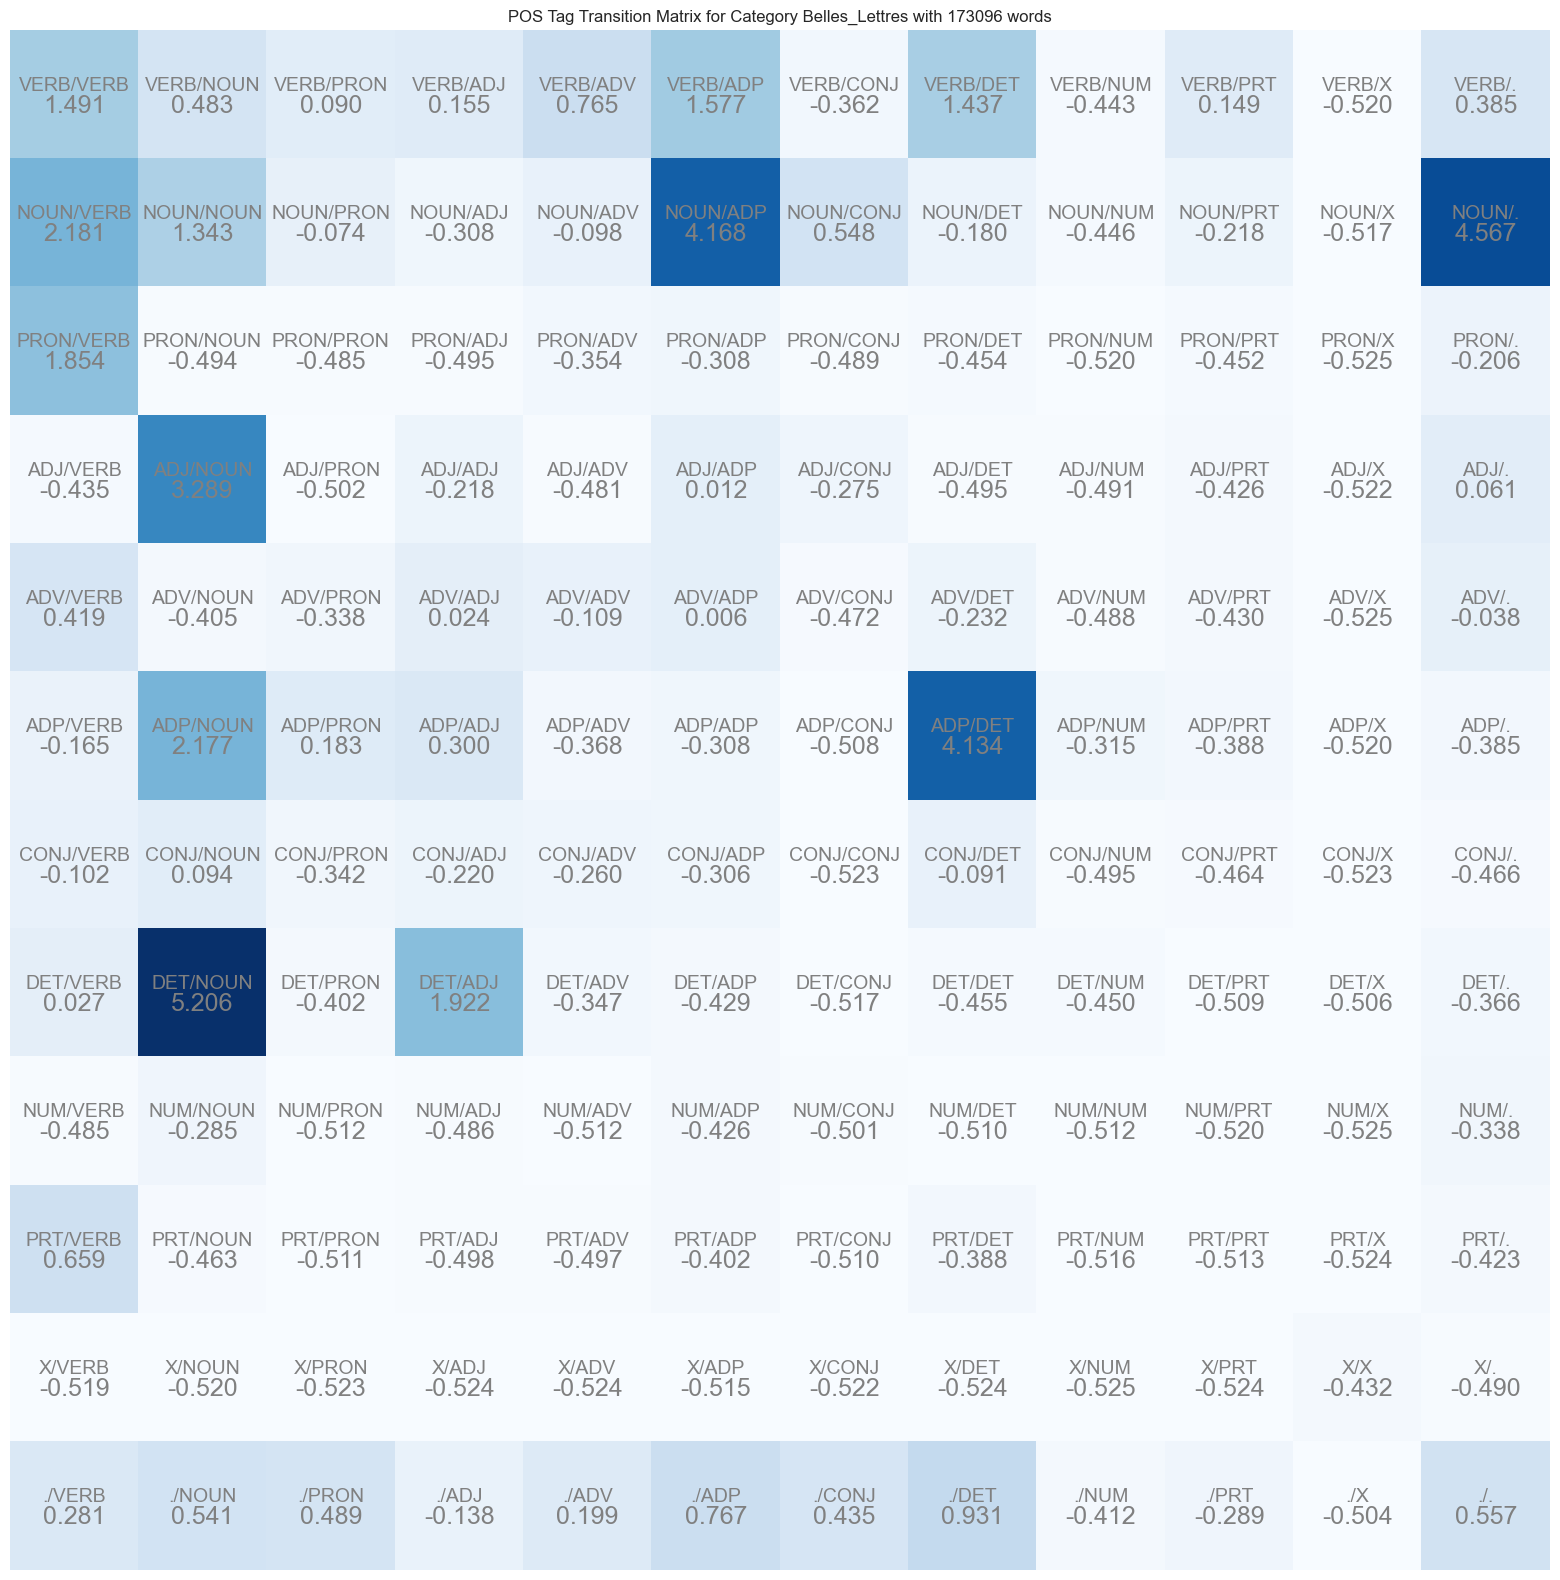

In [10]:
def plot_transition_matrix(tagged_words, title):
    counter = torch.zeros((len(tags), len(tags)), dtype=torch.int32)
    for pair_1, pair_2 in zip(tagged_words, tagged_words[1:]):
        counter[tag_to_embed[pair_1[1]], tag_to_embed[pair_2[1]]] += 1
    counter = counter.clone().detach().double()
    counter = (counter - counter.mean()) / counter.std()
    # counter = counter.norm()
    plt.figure(figsize=(20, 20))
    plt.imshow(counter, cmap="Blues")
    for i in range(counter.shape[0]):
        for j in range(counter.shape[1]):
            plt.text(j, i, embed_to_tag[i]+'/'+embed_to_tag[j], ha="center",
                    va="bottom", color="gray", fontdict={'size': 14})
            plt.text(j, i, f"{counter[i, j].item():.3f}", ha="center",
                    va="top", color="gray", fontdict={'size': 18})
    plt.title(title)
    plt.axis('off');

for cat in brown.categories()[:2]:
    brown_words = brown.tagged_words(categories=cat, tagset='universal')
    plot_transition_matrix(brown_words, f"POS Tag Transition Matrix for Category {cat.title()} with {len(brown_words)} words")


In [11]:
wn.synsets('dog', pos=wn.NOUN)

[Synset('dog.n.01'),
 Synset('frump.n.01'),
 Synset('dog.n.03'),
 Synset('cad.n.01'),
 Synset('frank.n.02'),
 Synset('pawl.n.01'),
 Synset('andiron.n.01')]

### Distance measure based on semantic tree traversal
**Idea:**

- Given a sentence, tag words into parts of speech using the Universal tagset (we prefer not to use the PennTreebank tagset as it is too English-specific and would not mesh well with WordNet).
- Filter only to nouns, adjectives, verbs, and adverbs. 
- Given each tagged word, we find its synset (i.e. the set of synonyms) in WordNet.
- Compute some distance metric between the synsets of the two words. For example, we can use the [Wu-Palmer similarity](https://www.nltk.org/howto/wordnet.html) measure.
- How do we calculate that for all the words in a given text/sentence? 

In [12]:
# This implementation is shit, aye?
from nltk.wsd import lesk
import pywsd as wsd

sentence = "The quick brown fox jumps over the lazy dog"
words = nltk.word_tokenize(sentence)
tagged = nltk.pos_tag(words, tagset='universal')
tag_to_wn = {'NOUN': wn.NOUN, 'VERB': wn.VERB, 'ADJ': wn.ADJ, 'ADV': wn.ADV}
for word, tag in tagged:
    if tag not in tag_to_wn.keys(): continue
    actual_word = wsd.simple_lesk(sentence, word, tag_to_wn[tag])
    print(
        f"{word} - {tag} - {actual_word, actual_word.definition() if actual_word else ''} - {wn.synsets(word, pos=tag_to_wn[tag])}")


Warming up PyWSD (takes ~10 secs)... 

quick - ADJ - (Synset('agile.s.01'), 'moving quickly and lightly') - [Synset('quick.s.01'), Synset('flying.s.02'), Synset('agile.s.01'), Synset('quick.s.04'), Synset('immediate.s.05'), Synset('quick.s.06')]
brown - NOUN - (Synset('brown_university.n.01'), 'a university in Rhode Island') - [Synset('brown.n.01'), Synset('brown.n.02'), Synset('brown.n.03'), Synset('brown_university.n.01')]
fox - NOUN - (Synset('fox.n.07'), 'the Algonquian language of the Fox') - [Synset('fox.n.01'), Synset('dodger.n.01'), Synset('fox.n.03'), Synset('fox.n.04'), Synset('fox.n.05'), Synset('fox.n.06'), Synset('fox.n.07')]
jumps - VERB - (Synset('startle.v.02'), 'move or jump suddenly, as if in surprise or alarm') - [Synset('jump.v.01'), Synset('startle.v.02'), Synset('jump.v.03'), Synset('jump.v.04'), Synset('leap_out.v.01'), Synset('jump.v.06'), Synset('rise.v.11'), Synset('jump.v.08'), Synset('derail.v.02'), Synset('chute.v.01'), Synset('jump.v.11'), Synset('jumpstart.v.01'), Synset('jump.v.13'), Synset('

took 3.2466981410980225 secs.
